In [272]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
import math
import pandas as pd

# Herramientas de graficado

In [273]:
def searchSpace(objective,dsignParms):
  if len(dsignParms)==1:
    x = np.linspace(dsignParms[0][0], dsignParms[0][1], 30)
    z=np.zeros(x.shape)
    for index,value in enumerate(x):
      #Se agrega un caso para el valor 0 que causa problemas de division entre 0 para algunas versiones de python
      if not (value==0.0):
        z[index]=objective(value)
      else:
        z[index]=0
    fig=plt.figure()  
    axes=fig.add_axes([0.1,0.1,0.8,0.8])
    axes.plot(x,z) 
    
  if len(dsignParms)==2:
    x = np.linspace(dsignParms[0][0], dsignParms[0][1], 30)
    y = np.linspace(dsignParms[1][0], dsignParms[1][1], 30)
    xv,yv = np.meshgrid(x, y)
  
    mi,mj=xv.shape
    z=np.zeros(xv.shape)
    for i in range(mi):
      for j in range(mj):
        z[i,j]=objective([xv[i,j],yv[i,j]])
    
    fig=plt.figure()  
    axes=Axes3D(fig)
    surf = axes.plot_surface(xv, yv, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  return fig,axes

In [274]:
def solutionPrint(objective,fig, axes, Historic):
  if len(Historic[0])==1:
    x=list()
    z=list()
    for data in Historic: 
      z.append(objective(data))
      x.append(data)
    axes.plot(x,z,c='r',marker='h') 
    plt.show()
  if len(Historic[0])==2:
    x=list()
    y=list()
    z=list()
    for data in Historic:
      z.append(objective(data))
      x.append(data[0])
      y.append(data[1])
    #print(axes)
    axes.plot(x,y,z,c='r',marker='h') 
    
    plt.show()

In [275]:
def GrafHist(histObje):
  fig=plt.figure()  
  axes=fig.add_axes([0.1,0.1,0.8,0.8])
  axes.plot(histObje) 
  plt.show()

# Algoritmos de Optimización


## Colonia Artificial de Abejas (ABC)

In [276]:
def abc(fobj, bounds, its=1000, foodsource=100, maxim=False, limitBee=5):
    #Init
    dimensions = len(bounds)
    min_b, max_b = np.asarray(bounds).T
    popsize=int(foodsource/dimensions)
    limit=(popsize*dimensions)
    trial=np.zeros((int(popsize), 1), dtype='f')
    probs=np.zeros((int(popsize), 1), dtype='f')    
    foodS=np.random.uniform(low=min_b, high=max_b, size=(popsize,dimensions))
    fx=np.asarray([fobj(i) for i in foodS])
    fitFun= lambda x : 1/(1+x) if (x>=0) else 1+abs(x)
    fit = np.asarray([fitFun(i) for i in fx])    
    BestFood=np.zeros((int(dimensions), 1), dtype='f')
    Bestfit=0.0
    Bestfun=0.0
    HistoricFood=list()
    HistoricFunction=list()
    for it in range(its):
        #ABEJAS EMPLEADAS
        count=0
        for i in foodS:
            a=np.random.randint(0, dimensions)
            b=np.random.randint(0, len(foodS))
            par=foodS[b,a]                
            while(par==i[a]):
                b=np.random.randint(0, len(foodS))
                par=foodS[b,a]
            xNew=(i[a])+(np.random.uniform(low=-1, high=1)) *(i[a]-par)
            if(xNew<min_b):
                xNew=min_b
            elif(xNew>max_b):
                xNew=max_b
            newFun=fobj(xNew)
            newFitFun=fitFun(newFun)               
            if(newFitFun>fit[b] and  maxim==False) or (newFitFun<=fit[b] and  maxim):
                foodS[count,a]=xNew
                fx[count]=newFun
                fit[count]=newFitFun
                trial[count]=0
            else:
                trial[count]+=1                            
            count+=1
        #ABEJAS ESPECTADORAS
        count=0
        probT=fit.sum()
        for i in fit:
            probs[count]=i/probT
            count+=1
        count=0
        for i in foodS:
            if (np.random.uniform(low=0, high=1)<probs[count]):
                par=foodS[b,a]                
                while(par==i[a]):
                    b=np.random.randint(0, len(foodS))
                    par=foodS[b,a]
                xNew=(i[a])+(np.random.uniform(low=-1, high=1)) *(i[a]-par)
                if(xNew<min_b):
                    xNew=min_b
                elif(xNew>max_b):
                    xNew=max_b
                newFun=fobj(xNew)
                newFitFun=fitFun(newFun)               
                if(newFitFun>fit[b] and  maxim==False) or (newFitFun<=fit[b] and  maxim):
                    foodS[count,a]=xNew
                    fx[count]=newFun
                    fit[count]=newFitFun
                    trial[count]=0
                else:
                    trial[count]+=1
                count+=1
        #Memoriza

        if(maxim):
            if(it==0):
                Bestfit=copy.deepcopy(np.min(fit))
            if(Bestfit>=np.min(fit)):                
                Bestfit= copy.deepcopy(np.min(fit))
                ixBest= int((np.where(fit==Bestfit))[0][0])
                BestFood=copy.deepcopy(foodS[ixBest])
                Bestfun=copy.deepcopy(fx[ixBest]  )
        else:
            if(it==0):
                Bestfit=copy.deepcopy(np.max(fit))
            if(Bestfit<=np.max(fit)):
                Bestfit= copy.deepcopy(np.max(fit))
                ixBest= int((np.where(fit==Bestfit))[0][0])
                BestFood=copy.deepcopy(foodS[ixBest])
                Bestfun=copy.deepcopy(fx[ixBest])
        HistoricFood.append(copy.deepcopy(BestFood))
        HistoricFunction.append(copy.deepcopy(Bestfun))
        #ABEJAS EXPLORADORAS
        count=0        
        for i in trial:
            if (i>limitBee):                
                foodN=np.random.uniform(low=min_b, high=max_b, size=(1,dimensions))                
                foodS[count]=foodN
                nfun=fobj(foodN)
                nfit=fitFun(nfun)                
                trial[count]=0          
                fx[count]=nfun
                fit[count]=nfit                
            count+=1
        
    return HistoricFood, HistoricFunction

## Problema del área mínima de una caja de volumen fijo ABC

In [277]:
prob_caja_volumen_restringido = (lambda x: (864/x)+x**2)

In [278]:
prob_caja_volumen_restringido(5)

197.8

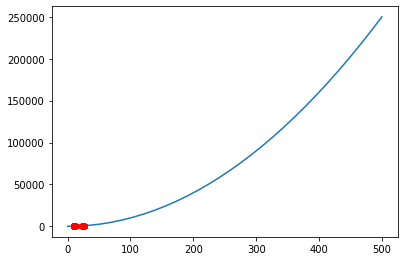

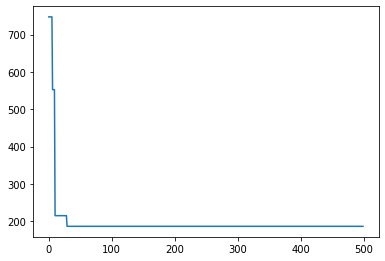

[9.97686742]
[186.13821242]


In [279]:
historicFood, historicFx = abc(prob_caja_volumen_restringido, bounds=[(0, 500)], its=500, foodsource=10, limitBee=10, maxim=False)


fig,axes=searchSpace(prob_caja_volumen_restringido,[[0, 500]])
solutionPrint(prob_caja_volumen_restringido,fig, axes, historicFood)
GrafHist(historicFx)

print(historicFood[-1])
print(historicFx[-1])



## Plan de inversión ABC

In [280]:
planDeInversion=(lambda x: (-(.001*x**2)) + (0.4*x) + (3.5))

In [281]:
planDeInversion(200)

43.5

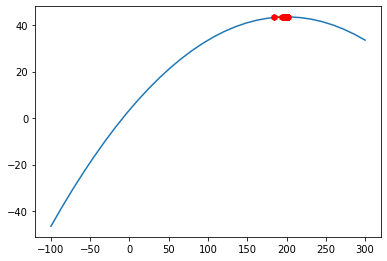

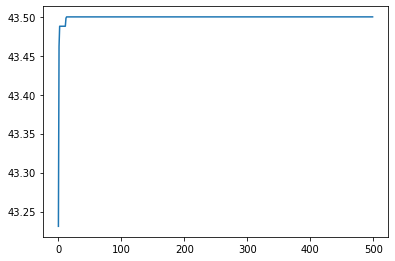

[200.01911335]
[43.49999963]


In [282]:
historicFood, historicFx = abc(planDeInversion, bounds=[(1, 300)], its=500, foodsource=10, limitBee=100, maxim=True)


fig,axes=searchSpace(planDeInversion,[[-100, 300]])
solutionPrint(planDeInversion,fig, axes, historicFood)
GrafHist(historicFx)
print(historicFood[-1])
print(historicFx[-1])


## Cuadrados ABC

In [283]:
cuadrados=(lambda x: ((((7)*(x**2))-(420*x)+9800)/8))

In [284]:
cuadrados(28)

441.0

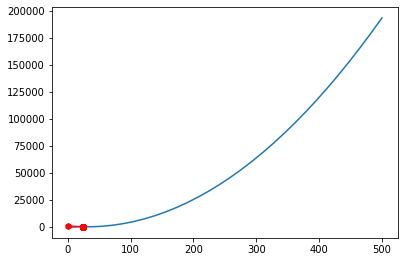

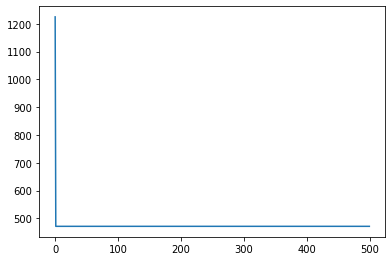

[23.75340886]
[471.64241329]


In [285]:
historicFood, historicFx = abc(cuadrados, bounds=[(0, 500)], its=500, foodsource=10, limitBee=100, maxim=False)


fig,axes=searchSpace(cuadrados,[[0, 500]])
solutionPrint(cuadrados,fig, axes, historicFood)
GrafHist(historicFx)
print(historicFood[-1])
print(historicFx[-1])
